## demo: 

In [50]:
library(gaia)
library(tidyr)
library(dplyr)
library(data.table)
library(ggplot2)

In [55]:
#library(tidyverse)
library(lubridate)
library(ggplot2)
library(RColorBrewer)
library(viridis)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: viridisLite



In [ ]:
## ggplot theme

my_theme <- function() {
    theme_classic() +
    theme( 
        plot.title = element_text(color="black", size=12, face="bold"),
        axis.title.x = element_text(color="black", size=20, face="bold", vjust=2),
        axis.title.y = element_text(color="black", size=20, face="bold", vjust=2),
        axis.text=element_text(size=24),
        )
}

options(repr.plot.width=14, repr.plot.height=8)

In [2]:
#?treeseq_discrete_mpr

## read tree sequence

In [2]:
filename = "demo.trees"

ts = treeseq_load(filename)

nodes = treeseq_nodes(ts)

edges = treeseq_edges(ts)

# view first local tree 
tree = treeseq_to_phylo(ts)

## extract sample nodes, locations

In [6]:
# identify sample nodes
samples <- subset(nodes, is_sample == 1L)

# use population_id as geography; drop missing-like values (e.g., -1)
ok       <- samples$population_id >= 0
samples  <- samples[ok, , drop = FALSE]

# remap unique population ids to 1..N_DEMES
pop_levels <- sort(unique(samples$population_id))
state_map  <- setNames(seq_along(pop_levels), pop_levels)
state_id   <- unname(state_map[ as.character(samples$population_id) ])

# georef table for gaia w/ node_id, state_id cols
sample_locations <- data.frame(
  node_id  = samples$node_id,
  state_id = state_id  # Make sure sample locations are 1-based (curr 0-based)
)

sample_locations <- as.matrix(sample_locations[, c("node_id","state_id")])
storage.mode(sample_locations) <- "integer"
colnames(sample_locations) <- c("node_id","state_id")

In [7]:
sample_locations

node_id,state_id
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


## define cost matrix 

In [ ]:
# correct this -- cost not transition matrix 

In [5]:
cost.mat = data.matrix(read.csv("uninformative_cost.csv", row.names=1))[1:3, 1:3]
dimnames(cost.mat) = NULL
cost.mat

0,1,1
1,0,1
1,1,0


## run mpr function 

In [68]:
#?treeseq_discrete_mpr

In [67]:
#?treeseq_discrete_mpr_minimize

In [8]:
mpr = treeseq_discrete_mpr(ts, sample_locations, cost.mat)
estimated_node_states = treeseq_discrete_mpr_minimize(mpr) 

In [9]:
estimated_node_states ## node states for the entire tree sequence. 

[1] 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 2 2 1 2 2 3 1 2
[39] 1 3 2 3 1 2 1 3 3 1 1 3 3 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 2 3 1 3

Method applies DTA on per-tree basis. For nodes that appear across multiple trees, the cheapest average location is chosen. 

In [27]:
node_states_df <- data.frame(node_time=nodes$time, node_state=nodes$population_id+1L, 
    estimated_node_state=estimated_node_states)

node_states_df$node <- 0:(nrow(node_states_df) -1)

head(node_states_df)

node_time,node_state,estimated_node_state,node
<dbl>,<int>,<int>,<int>
0,1,1,0
0,1,1,1
0,1,1,2
0,1,1,3
0,1,1,4
0,1,1,5
0,1,1,6
0,1,1,7
0,1,1,8


### Calculate bin-wise accuracy 
Pbin = proportion correctly labeled states / total number of states 

In [14]:
locations_sim <- read.csv('locations_df.csv')
head(locations_sim)

index,sample_a,sample_b,left,right,mrca_population,type,node,bin,position
<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>
0,0,1,0,1897,pop_0,sim,55,0,0
0,0,2,0,1897,pop_0,sim,55,0,0
0,0,3,0,1897,pop_0,sim,67,0,0
0,0,4,0,1897,pop_0,sim,44,0,0
0,0,5,0,1897,pop_0,sim,55,0,0
0,0,6,0,1897,pop_0,sim,67,0,0
0,0,7,0,1897,pop_0,sim,67,0,0
0,0,8,0,1897,pop_0,sim,42,0,0
0,0,9,0,1897,pop_1,sim,53,0,0


In [34]:
# match up w/ internal node locations(constant) from gaia ->
merged <- left_join(locations_sim, node_states_df, by = 'node')
head(merged)

index,sample_a,sample_b,left,right,mrca_population,type,node,bin,position,node_time,node_state,estimated_node_state
<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>
0,0,1,0,1897,pop_0,sim,55,0,0,1470.6860,1,1
0,0,2,0,1897,pop_0,sim,55,0,0,1470.6860,1,1
0,0,3,0,1897,pop_0,sim,67,0,0,13415.0423,1,2
0,0,4,0,1897,pop_0,sim,44,0,0,211.4219,1,1
0,0,5,0,1897,pop_0,sim,55,0,0,1470.6860,1,1
0,0,6,0,1897,pop_0,sim,67,0,0,13415.0423,1,2
0,0,7,0,1897,pop_0,sim,67,0,0,13415.0423,1,2
0,0,8,0,1897,pop_0,sim,42,0,0,197.3244,1,1
0,0,9,0,1897,pop_1,sim,53,0,0,858.7261,2,1


In [47]:
# calculate! maybe an average score per bin and then just a scatter/violin plot
score <- merged %>% 
    mutate(merged, is_correct = case_when(node_state == estimated_node_state ~ 1, node_state != estimated_node_state ~ 0)) %>%
    group_by(bin, position) %>%
    summarise(pbin = mean(is_correct)) 

head(score)

`summarise()` has grouped output by 'bin'. You can override using the `.groups` argument.


### Plot scores

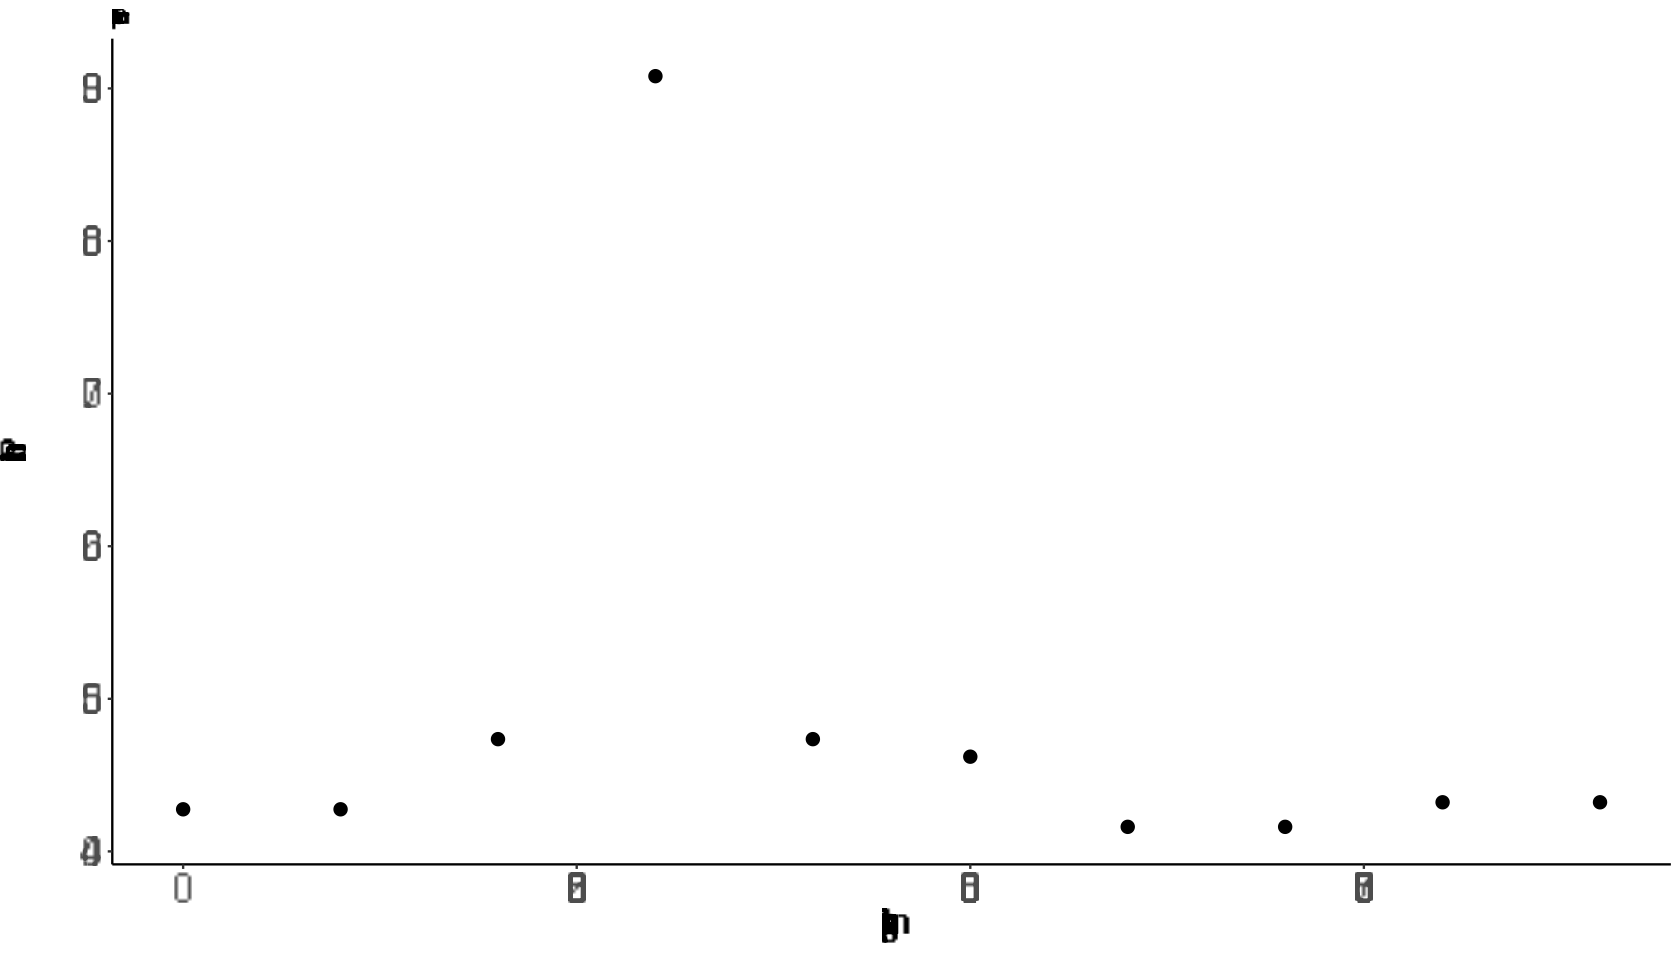

In [73]:
score %>% ggplot(aes(x = position, y = pbin)) + geom_point(size = 3) +
            my_theme() + 
            ylab('Pbin') + xlab('genomic position') + ggtitle('Pbin with uninformative prior')